---
title: "DSA4213 Assignment 2: Build and Compare Small Language Models"
author: "Nguyen Cao Duy (A0258078R)"
# date: "today"
execute:
    echo: false
    output: false
format: 
  typst:
    toc: true
    margin:
      x: 1cm
      y: 1cm
    include-in-header:
        - text: |
            /* Color links */
            #show link: set text(fill: rgb(0, 0, 255))
# bibliography: references.bib
---

In [1]:
import gc
import math
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import requests
import sentencepiece as spm
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
DATA_DIR = "data"
MODEL_DIR = "models"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

Using device: cpu


## 1. Data

### 1.1 Corpus Introduction

For this assignment, I use Arthur Conan Doyle's entire [Sherlock Holmes works](https://sherlock-holm.es/ascii/) as a corpus of around 650,000 words (almost 4 millions characters). The text is then split into training (80%), validation (10%), and test (10%) sets.

In [2]:
CORPUS_URL = "https://sherlock-holm.es/stories/plain-text/cano.txt"
CORPUS_PATH = os.path.join(DATA_DIR, "corpus.txt")
if not os.path.exists(CORPUS_PATH):
    print("Downloading corpus...")
    r = requests.get(CORPUS_URL)
    with open(CORPUS_PATH, "w") as f:
        f.write(r.text)
    print("Download complete.")
else:
    print("Corpus already downloaded.")

Corpus already downloaded.


In [3]:
with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    corpus = f.read()

# Train/Val/Test Split (80/10/10)
n = len(corpus)
train_text = corpus[:int(n*0.8)]
val_text = corpus[int(n*0.8):int(n*0.9)]
test_text = corpus[int(n*0.9):]
test_text = test_text[:len(test_text)//10]  # Use only first half of test set for faster evaluation

print(f"Total characters: {n}")
print(f"Train size: {len(train_text)} | Val size: {len(val_text)} | Test size: {len(test_text)}")

Total characters: 3868223
Train size: 3094578 | Val size: 386822 | Test size: 38682


### 1.2 Tokenization

We explore three tokenization strategies for our ablation study (to be discussed later):

- **Word-level**: Words are separated by whitespace, resulting in a vocabulary size of **~40,000**.
- **Subword-level**: Using a Byte Pair Encoding (BPE) variant through the `sentencepiece` library, we train a subword tokenizer with a vocabulary size of **2,000**.
- **Character-level**: Each character is treated as a token, resulting in a vocabulary size of **~100**.

In [4]:
class WordTokenizer:
    def __init__(self, text):
        self.words = sorted(list(set(text.split())))
        self.vocab_size = len(self.words)
        self.word_to_idx = {word: i for i, word in enumerate(self.words)}
        self.idx_to_word = {i: word for i, word in enumerate(self.words)}
        # Add an <unk> token for out-of-vocabulary words
        self.unk_token_idx = self.vocab_size
        self.vocab_size += 1

    def encode_to_pieces(self, text):
        return text.split()

    def encode(self, text):
        return [self.word_to_idx.get(word, self.unk_token_idx) for word in text.split()]

    def decode(self, ids):
        return ' '.join([self.idx_to_word.get(i, '<unk>') for i in ids])
    
word_tokenizer = WordTokenizer(train_text)
print(f"Word tokenizer vocab size: {word_tokenizer.vocab_size}")

Word tokenizer vocab size: 39749


In [5]:
SPM_MODEL_PREFIX = os.path.join(MODEL_DIR, "spm_bpe")
SPM_MODEL_PATH = f"{SPM_MODEL_PREFIX}.model"
VOCAB_SIZE = 2000

if not os.path.exists(SPM_MODEL_PATH):
    print("Training a custom SentencePiece BPE model...")
    temp_train_file = os.path.join(DATA_DIR, "temp_train_spm.txt")
    with open(temp_train_file, "w", encoding="utf-8") as f:
        f.write(train_text)
    spm.SentencePieceTrainer.train(
        input=temp_train_file, model_prefix=SPM_MODEL_PREFIX, vocab_size=VOCAB_SIZE, 
        model_type='bpe',
        minloglevel=2,
    )
    print(f"SentencePiece model trained and saved to {SPM_MODEL_PATH}")
    os.remove(temp_train_file)

# Just a wrapper for consistency with my other tokenizers
class SubwordTokenizer:
    def __init__(self, model_path):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.vocab_size = self.sp.get_piece_size()

    def encode_to_pieces(self, text):
        return self.sp.encode_as_pieces(text)

    def encode(self, text):
        return self.sp.encode_as_ids(text)

    def decode(self, ids):
        return self.sp.decode_ids(ids)

subword_tokenizer = SubwordTokenizer(os.path.join(MODEL_DIR, "spm_bpe.model"))
print(f"Custom SentencePiece tokenizer loaded with vocab size: {subword_tokenizer.vocab_size}")

Custom SentencePiece tokenizer loaded with vocab size: 2000


In [6]:
class CharTokenizer:
    def __init__(self, text):
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        # Add an <unk> token for out-of-vocabulary characters
        self.unk_token_idx = self.vocab_size
        self.vocab_size += 1

    def encode_to_pieces(self, text):
        return list(text)

    def encode(self, text):
        return [self.char_to_idx.get(ch, self.unk_token_idx) for ch in text]

    def decode(self, ids):
        return ''.join([self.idx_to_char.get(i, '<unk>') for i in ids])

char_tokenizer = CharTokenizer(train_text)
print(f"Character tokenizer vocab size: {char_tokenizer.vocab_size}")

Character tokenizer vocab size: 100


In [7]:
#| output: true
sample_text = "Is Holmes alive? I didn't see him."
print("--- Sample text ---")
print(sample_text)
print("--- Word-level Tokenization ---")
print("Tokens:", word_tokenizer.encode_to_pieces(sample_text))
# print("Token IDs:", word_tokenizer.encode(sample_text))
print("--- Subword-level Tokenization ---")
print("Tokens:", subword_tokenizer.encode_to_pieces(sample_text))
# print("Token IDs:", subword_tokenizer.encode(sample_text))
print("--- Character-level Tokenization ---")
print("Tokens:", char_tokenizer.encode_to_pieces(sample_text))
# print("Token IDs:", char_tokenizer.encode(sample_text))

--- Sample text ---
Is Holmes alive? I didn't see him.
--- Word-level Tokenization ---
Tokens: ['Is', 'Holmes', 'alive?', 'I', "didn't", 'see', 'him.']
--- Subword-level Tokenization ---
Tokens: ['▁I', 's', '▁Holmes', '▁al', 'ive', '?', '▁I', '▁did', 'n', "'", 't', '▁see', '▁him', '.']
--- Character-level Tokenization ---
Tokens: ['I', 's', ' ', 'H', 'o', 'l', 'm', 'e', 's', ' ', 'a', 'l', 'i', 'v', 'e', '?', ' ', 'I', ' ', 'd', 'i', 'd', 'n', "'", 't', ' ', 's', 'e', 'e', ' ', 'h', 'i', 'm', '.']


In [8]:
class TextDataset(Dataset):
    def __init__(self, text, tokenizer, seq_len):
        self.seq_len = seq_len
        self.tokens = tokenizer.encode(text)

    def __len__(self):
        return len(self.tokens) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.tokens[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.tokens[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y

## 2. Models

We explore two models for this assignment: Long Short-Term Memory (LSTM) and Transformer (decoder-only). The brief descriptions of the models are as follows:

1. Embedding layer: Maps input tokens to vectors (sinusoidal positional encoding is added for the Transformer).
2. Main layer: Stacks of either LSTM layers or Transformer decoder layers.
3. Output layer: A linear layer followed by a softmax to predict the next token.

Dropout and Layer Normalization are used to improve generalization and training stability. Pytorch is used to implement both models, and training is done on a single P100 GPU on Kaggle.

In [9]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden=None):
        x = self.dropout(self.embedding(x))
        logits, hidden = self.lstm(x, hidden)
        logits = self.ln(logits)
        logits = self.fc(logits)
        return logits, hidden

    @torch.no_grad()
    def generate(self, start_ids, max_len=100, temperature=1.0):
        self.eval()
        input_ids = torch.tensor(start_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
        generated_ids = list(start_ids)
        hidden = None
        
        for _ in range(max_len):
            current_input = input_ids[:, -1].unsqueeze(1)
            logits, hidden = self(current_input, hidden)
            last_logits = logits[:, -1, :]
            
            scaled_logits = last_logits / temperature
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
            
            next_token_id = torch.multinomial(probs, 1).item()
            generated_ids.append(next_token_id)
            input_ids = torch.tensor([[next_token_id]], dtype=torch.long, device=DEVICE)

        self.train()
        return generated_ids

In [10]:
# Reference: https://nlp.seas.harvard.edu/annotated-transformer
# Reference: https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py

class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, max_seq_len, embed_size, num_heads, hidden_size, num_layers, dropout):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size, dropout, max_seq_len)

        # Using TransformerEncoderLayer with causal mask for language modeling
        # Pytorch TransformerDecoderLayer has both self-attention and cross-attention (which we don't need here)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=hidden_size, # 4 * embed_size
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)
        self.ln = nn.LayerNorm(embed_size)

    def forward(self, x):
        B, T = x.size()
        x = self.embedding(x)
        x = self.pos_encoder(x) # already includes dropout

        # Causal mask to ensure that attention is only applied to previous tokens in the sequence
        mask = torch.triu(torch.ones(T, T, device=DEVICE), diagonal=1).bool()
        x = self.transformer(x, mask)

        x = self.ln(x)
        logits = self.fc(x)

        return logits

    @torch.no_grad()
    def generate(self, start_ids, max_len=100, temperature=1.0):
        self.eval()
        input_ids = torch.tensor([start_ids], dtype=torch.long, device=DEVICE)
        
        for _ in range(max_len):
            # Crop context to max_seq_len
            idx_cond = input_ids[:, -self.max_seq_len:]
            logits = self(idx_cond)
            last_logits = logits[:, -1, :]

            scaled_logits = last_logits / temperature
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)

            next_token_id = torch.multinomial(probs, 1)
            input_ids = torch.cat((input_ids, next_token_id), dim=1)

        self.train()
        return input_ids[0].tolist()

In [11]:
# Reusable functions for evaluation, and plotting results.
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    is_lstm = isinstance(model, LSTMLanguageModel)

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            
            if is_lstm:
                hidden = (torch.zeros(model.lstm.num_layers, xb.size(0), model.lstm.hidden_size).to(DEVICE),
                          torch.zeros(model.lstm.num_layers, xb.size(0), model.lstm.hidden_size).to(DEVICE))
                logits, _ = model(xb, hidden)
            else: # Transformer
                logits = model(xb)
            
            loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))
            total_loss += loss.item()
            
    return total_loss / len(dataloader)

def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    iterations = [i * EVAL_INTERVAL for i in range(1, len(train_losses) + 1)]
    plt.plot(iterations, train_losses, label="Training Loss")
    plt.plot(iterations, val_losses, label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Cross-Entropy Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## 3. Experiments and Results

Each experiment consists of training the models for **20,000** iterations (each iteration processes one batch of data). This is better for comparison, as the number of training iterations per epoch can vary based on the tokenization strategy (i.e., 1 epoch for word-level tokenization has fewer iterations than character-level tokenization due to the longer sequences).

The best model is saved based on the lowest validation loss during training (evaluated every **2,000** iterations). Finally, it is evaluated on the test set to report the final test loss and perplexity.

To keep the training consistent, we will use these shared settings across all experiments: Dropout: $0.2$, Batch size: $64$, Optimizer: AdamW with learning rate $5 \times 10^{-4}$

In [12]:
MAX_ITER = 20000
EVAL_INTERVAL = 2000
DROPOUT = 0.2
LEARNING_RATE = 5e-4
BATCH_SIZE = 64

In [13]:
def run_experiment(config, generate_only=False, prompt="", temperature=1.0):
    model_path = os.path.join(MODEL_DIR, f"{config['name']}.pt")
    
    # 1. Setup data
    if config['tokenizer'] == 'word':
        tokenizer = word_tokenizer
        max_gen_len = 20
    elif config['tokenizer'] == 'subword':
        tokenizer = subword_tokenizer
        max_gen_len = 40
    else:
        tokenizer = char_tokenizer
        max_gen_len = 100
    train_dataset = TextDataset(train_text, tokenizer, config['seq_len'])
    val_dataset = TextDataset(val_text, tokenizer, config['seq_len'])
    test_dataset = TextDataset(test_text, tokenizer, config['seq_len'])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # 2. Setup model
    vocab_size = tokenizer.vocab_size
    if config['model_type'] == 'lstm':
        model = LSTMLanguageModel(
            vocab_size=vocab_size,
            embed_size=config['embed_size'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            dropout=DROPOUT
        ).to(DEVICE)
    else:
        model = TransformerLanguageModel(
            vocab_size=vocab_size,
            max_seq_len=config['seq_len'],
            embed_size=config['embed_size'],
            num_heads=config['hidden_size'] // config['embed_size'], # Should be 4
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            dropout=DROPOUT
        ).to(DEVICE)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
    if not generate_only:
        print(f"--- Model: {config['name']} | Parameters: {num_params:.2f}M ---")
        
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # 3. Train or Load Model
    if os.path.exists(model_path):
        # print(f"Loading pre-trained model: {config['name']}")
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        train_losses, val_losses, training_time = [], [], 0
    else:
        print(f"--- Starting Training: {config['name']} ---")
        train_losses, val_losses = [], []
        best_val_loss = float('inf')
        start_time = time.time()
        
        model.train()
        is_lstm = isinstance(model, LSTMLanguageModel)
        iteration = 0
        train_loss_accum = 0
        train_iter = iter(train_loader)

        with tqdm(total=MAX_ITER, desc="Training") as pbar:
            while iteration < MAX_ITER:
                try:
                    xb, yb = next(train_iter)
                except StopIteration:
                    # Reset iterator when we reach the end of an epoch
                    train_iter = iter(train_loader)
                    xb, yb = next(train_iter)
                
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)

                if is_lstm:
                    hidden = (torch.zeros(model.lstm.num_layers, xb.size(0), model.lstm.hidden_size).to(DEVICE),
                              torch.zeros(model.lstm.num_layers, xb.size(0), model.lstm.hidden_size).to(DEVICE))
                    logits, _ = model(xb, hidden)
                else:  # Transformer
                    logits = model(xb)

                loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                train_loss_accum += loss.item()
                iteration += 1

                # Evaluate at specified intervals
                if iteration % EVAL_INTERVAL == 0:
                    avg_train_loss = train_loss_accum / EVAL_INTERVAL
                    val_loss = evaluate(model, val_loader, criterion)
                    
                    train_losses.append(avg_train_loss)
                    val_losses.append(val_loss)
                    
                    print(f"\nIteration {iteration} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PPL: {math.exp(val_loss):.4f}")
                    
                    # Save best model so far
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        torch.save(model.state_dict(), model_path)
                        print("Saved best model.")
                    
                    train_loss_accum = 0
                    model.train()  # Reset to training mode after evaluation
                
                pbar.update(1)

        training_time = time.time() - start_time
        plot_losses(train_losses, val_losses, f"Loss Curves for {config['name']}")

    # 4. Final Evaluation
    if not generate_only:
        # print(f"--- Evaluating on Test Set: {config['name']} ---")
        test_loss = evaluate(model, test_loader, criterion)
        test_ppl = math.exp(test_loss)
        print(f"Test Loss: {test_loss:.4f} | Test Perplexity: {test_ppl:.4f}")

    # 5. Generation Example
    if generate_only:
        context = tokenizer.encode(prompt)
        print(f"--- Generation from {config['name']} (temp={temperature}) ---")
        # print(f"Prompt: {prompt}")
        # print("Generated Text:")
        print(tokenizer.decode(model.generate(context, max_gen_len, temperature)[len(context):]))

    # 6. Cleanup
    del model, optimizer, train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    if generate_only:
        return
    
    # 7. Return results
    results = {
        'name': config['name'],
        'num_params_millions': num_params,
        'test_perplexity': test_ppl,
        'training_time': training_time,
    }
    return results

### 3.1 Tokenization Experiments

We compare the performance of the two models (LSTM and Transformer) across the three tokenization strategies (word-level, subword-level, and character-level). For both models, we fix some hyperparameters to ensure a fair comparison: Embedding size: $64$, Hidden size: $256$, Number of layers: $2$, Sequence length: $64$. Even with these shared settings, the number of parameters might differ between models due to their different architectures.

| Model                     | # Params (M) | Test Loss | Test Perplexity | Training Time |
| ------------------------- | ------------ | --------- | --------------- | ------------- |
| **LSTM + Word**           | 13.62        | 6.93      | 1025.40         | 27m 03s       |
| **LSTM + Subword**        | 1.50         | 3.94      | 51.44           | 7m 21s        |
| **LSTM + Char**           | 0.89         | 1.18      | 3.26            | 10m 48s       |
| **Transformer + Word**    | 5.23         | 6.84      | 936.35          | 12m 50s       |
| **Transformer + Subword** | 0.36         | 4.17      | 64.92           | 3m 31s        |
| **Transformer + Char**    | 0.11         | 1.63      | 5.10            | 5m 16s        |

As we move from character-level to word-level tokenization, the model size increases significantly because of the larger vocabulary size. Surprisingly, the subword-level tokenization has lower training time than character-level tokenization despite having a larger model size, maybe due to the `sentencepiece` library's tokenization efficiency. 

Test perplexity decreases as we move from word-level to character-level tokenization, indicating that models are more confident in their predictions. However, this might be due to the smaller vocabulary size, and does not necessarily mean better text generation quality. As we can see from the sample generations below, character-level models usually produce typos and nonsensical words, while word-level and subword-level models generate more coherent text.

**Note**: A limitation of our word-level tokenization is that it does not handle punctuation properly since we only split by whitespace (some punctuation marks are attached to words). This might explain the poor performance of word-level models in perplexity.

In [14]:
# EMBED_SIZE = 64
# HIDDEN_SIZE = EMBED_SIZE * 4
# NUM_LAYERS = 2
# SEQ_LEN = 64

# CODE_NAME = f"{EMBED_SIZE}e-{HIDDEN_SIZE}h-{NUM_LAYERS}l-{SEQ_LEN}s"

experiments = [
    {'name': 'lstm_word_64e-256h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'word', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'lstm_subword_64e-256h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'lstm_char_64e-256h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'char', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_word_64e-256h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'word', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_subword_64e-256h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_char_64e-256h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'char', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
]

results_log = {}
for exp_config in experiments:
    results_log[exp_config['name']] = run_experiment(exp_config)
    print()

--- Model: lstm_word_64e-256h-2l-64s | Parameters: 13.62M ---
Test Loss: 6.9328 | Test Perplexity: 1025.4046

--- Model: lstm_subword_64e-256h-2l-64s | Parameters: 1.50M ---
Test Loss: 3.9404 | Test Perplexity: 51.4396

--- Model: lstm_char_64e-256h-2l-64s | Parameters: 0.89M ---
Test Loss: 1.1820 | Test Perplexity: 3.2609

--- Model: transformer_word_64e-256h-2l-64s | Parameters: 5.23M ---
Test Loss: 6.8420 | Test Perplexity: 936.3504

--- Model: transformer_subword_64e-256h-2l-64s | Parameters: 0.36M ---
Test Loss: 4.1731 | Test Perplexity: 64.9186

--- Model: transformer_char_64e-256h-2l-64s | Parameters: 0.11M ---
Test Loss: 1.6287 | Test Perplexity: 5.0970



In [15]:
#| output: true
prompt = "Sherlock Holmes took his bottle from the corner of the room"
print(f"--- Prompt: '{prompt}' ---")
for exp_config in experiments:
    run_experiment(exp_config, generate_only=True, prompt=prompt)
    print()

--- Prompt: 'Sherlock Holmes took his bottle from the corner of the room' ---
--- Generation from lstm_word_64e-256h-2l-64s (temp=1.0) ---
on the moor. "You can surely say that. The bird was the man who wrote in the interest I should

--- Generation from lstm_subword_64e-256h-2l-64s (temp=1.0) ---
where the hinges was seated by and lit the termmer all miners. The man was waiting at the back, but was the portrer Tener which hung

--- Generation from lstm_char_64e-256h-2l-64s (temp=1.0) ---
eant we were allowing together.  I
     saw the groan who had roined, kindly oaken as of our prompt.

--- Generation from transformer_word_64e-256h-2l-64s (temp=1.0) ---
knocked I have done of San our mantelpiece. and absolutely Edwards," of one of the scrub, of the bell, that

--- Generation from transformer_subword_64e-256h-2l-64s (temp=1.0) ---
. It was a dark head. The band-ag, when this lady began to having held out into a good side. There was no flower and seally unless streed case

--- Generati

Looking at the training curves below, we can see that word-level models overfit very quickly, while character-level models take much longer to converge. Our subword-level models strike a good balance between the two.

At this small scale, LSTM models perform better than Transformer models in terms of perplexity, but they take longer to train and seem to overfit faster.

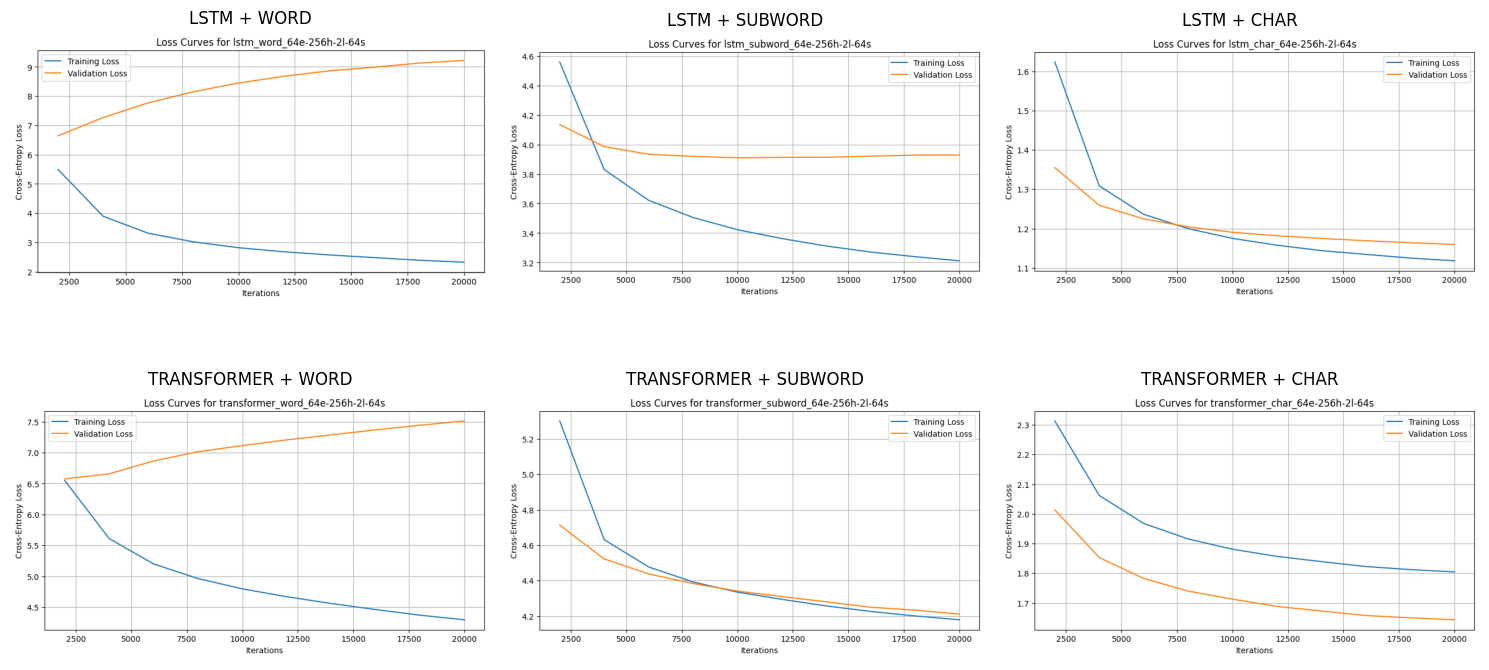

In [17]:
#| output: true
tokenizers = ["word", "subword", "char"]
models = ["lstm", "transformer"]
fig, axes = plt.subplots(len(models), len(tokenizers), figsize=(15, 8))
for i, model_type in enumerate(models):
    for j, tok in enumerate(tokenizers):
        ax = axes[i, j]
        matching = [exp for exp in results_log if exp.startswith(f"{model_type}_{tok}")]
        exp_name = matching[0]
        fig_path = os.path.join("figures", f"{exp_name}.png")
        img = Image.open(fig_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{model_type.upper()} + {tok.upper()}")
plt.tight_layout()
plt.show()

### 3.2 Model Scaling Experiments

We compare the performance of the two models (LSTM and Transformer) using subword-level tokenization, while varying the model sizes. Using the following settings as the baseline: Embedding size: $64$, Hidden size: $256$, Number of layers: $2$, Sequence length: $64$. We then scale the models up and down by adjusting one hyperparameter at a time, while keeping the others fixed.

#### 3.2.1 Varying Embedding Size

We conduct experiments by varying the embedding size for both LSTM and Transformer models in {32, 64, 128}, and also update the hidden size as 4 times the embedding size to maintain a balanced architecture.

| Model            | Params (M) | Test Loss | Test Perplexity | Training Time (s) |
| ---------------- | ---------- | --------- | --------------- | ----------------- |
| LSTM 32e         | 0.54       | 3.98      | 53.38           | 4m 16s            |
| LSTM 64e         | 1.50       | 3.94      | 51.44           | 7m 21s            |
| LSTM 128e        | 4.70       | 3.93      | 50.77           | 33m 51s           |
| Transformer 32e  | 0.16       | 4.43      | 83.65           | 3m 40s            |
| Transformer 64e  | 0.36       | 4.17      | 64.92           | 3m 31s            |
| Transformer 128e | 0.91       | 3.94      | 51.25           | 9m 38s            |


In [18]:
experiments = [
    {'name': 'lstm_subword_32e-128h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 32, 'hidden_size': 128, 'num_layers': 2, 'seq_len': 64},
    {'name': 'lstm_subword_64e-256h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'lstm_subword_128e-512h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 128, 'hidden_size': 512, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_subword_32e-128h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 32, 'hidden_size': 128, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_subword_64e-256h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_subword_128e-512h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 128, 'hidden_size': 512, 'num_layers': 2, 'seq_len': 64},
]

results_log = {}
for exp_config in experiments:
    results_log[exp_config['name']] = run_experiment(exp_config)
    print()

--- Model: lstm_subword_32e-128h-2l-64s | Parameters: 0.54M ---
Test Loss: 3.9775 | Test Perplexity: 53.3819

--- Model: lstm_subword_64e-256h-2l-64s | Parameters: 1.50M ---
Test Loss: 3.9404 | Test Perplexity: 51.4396

--- Model: lstm_subword_128e-512h-2l-64s | Parameters: 4.70M ---
Test Loss: 3.9272 | Test Perplexity: 50.7666

--- Model: transformer_subword_32e-128h-2l-64s | Parameters: 0.16M ---
Test Loss: 4.4266 | Test Perplexity: 83.6452

--- Model: transformer_subword_64e-256h-2l-64s | Parameters: 0.36M ---
Test Loss: 4.1731 | Test Perplexity: 64.9186

--- Model: transformer_subword_128e-512h-2l-64s | Parameters: 0.91M ---
Test Loss: 3.9367 | Test Perplexity: 51.2496



As we can see from the test perplexity above, increasing the embedding size improves the model's performance, especially for the Transformer model. However, the improvement is marginal in the case of the LSTM model. The training curves below also show that LSTM models are more susceptible to overfitting with larger embedding sizes, while Transformer models benefit more from the increased capacity.

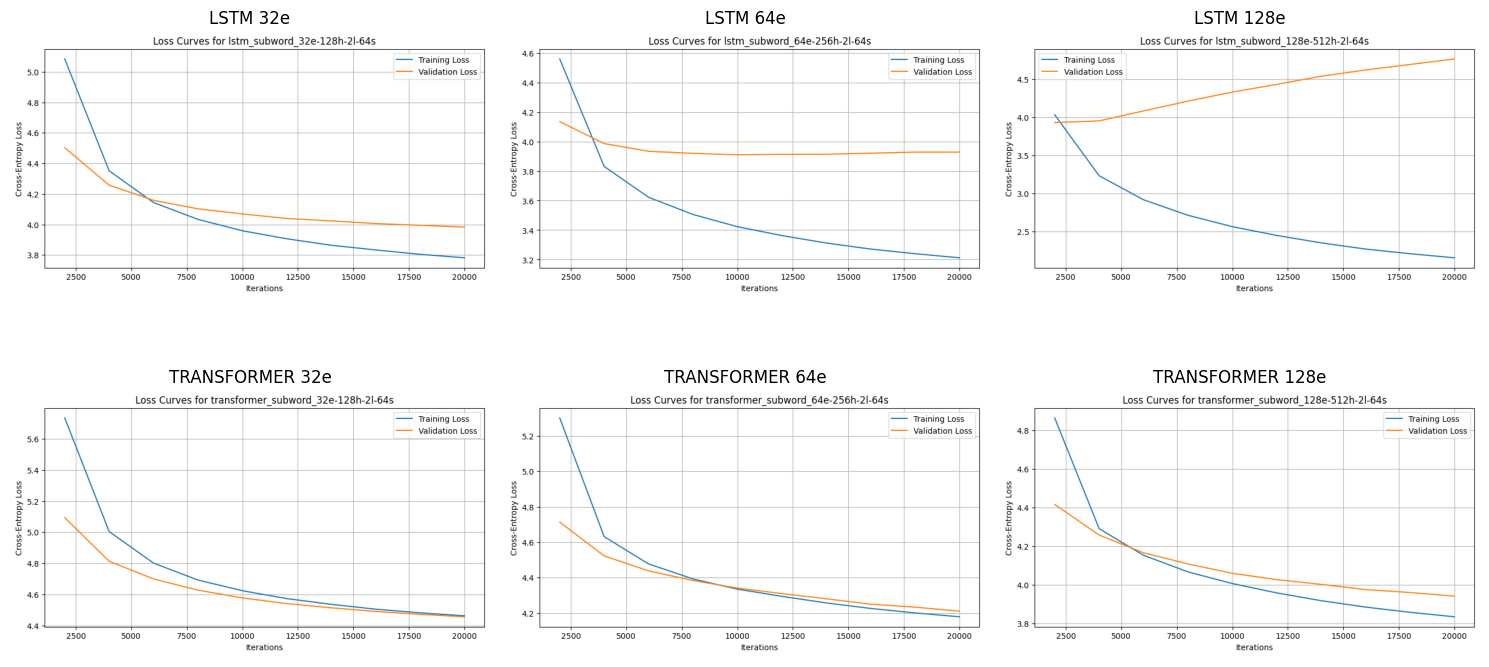

In [19]:
#| output: true
sizes = ["32", "64", "128"]
models = ["lstm", "transformer"]
fig, axes = plt.subplots(len(models), len(sizes), figsize=(15, 8))
for i, model_type in enumerate(models):
    for j, size in enumerate(sizes):
        ax = axes[i, j]
        matching = [exp for exp in results_log if exp.startswith(f"{model_type}_subword_{size}e")]
        exp_name = matching[0]
        fig_path = os.path.join("figures", f"{exp_name}.png")
        img = Image.open(fig_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{model_type.upper()} {size}e")
plt.tight_layout()
plt.show()

#### 3.2.2 Varying Number of Layers

We conduct experiments by varying the number of layers for both LSTM and Transformer models in {1, 2, 3}.

| Model          | Params (M) | Test Loss | Test Perplexity | Training Time (s) |
| -------------- | ---------- | --------- | --------------- | ----------------- |
| LSTM 1L        | 0.97       | 3.98      | 53.56           | 4m 45s            |
| LSTM 2L        | 1.50       | 3.94      | 51.44           | 7m 21s            |
| LSTM 3L        | 2.02       | 3.92      | 50.41           | 9m 55s            |
| Transformer 1L | 0.31       | 4.24      | 69.23           | 2m 51s            |
| Transformer 2L | 0.36       | 4.17      | 64.92           | 3m 31s            |
| Transformer 3L | 0.41       | 4.12      | 61.30           | 4m 24s            |


In [20]:
experiments = [
    {'name': 'lstm_subword_64e-256h-1l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 1, 'seq_len': 64},
    {'name': 'lstm_subword_64e-256h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'lstm_subword_64e-256h-3l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 3, 'seq_len': 64},
    {'name': 'transformer_subword_64e-256h-1l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 1, 'seq_len': 64},
    {'name': 'transformer_subword_64e-256h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_subword_64e-256h-3l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 3, 'seq_len': 64},
]

results_log = {}
for exp_config in experiments:
    results_log[exp_config['name']] = run_experiment(exp_config)
    print()

/Users/ncduy/.venv/dsa4213-assignment-2/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


--- Model: lstm_subword_64e-256h-1l-64s | Parameters: 0.97M ---
Test Loss: 3.9808 | Test Perplexity: 53.5593

--- Model: lstm_subword_64e-256h-2l-64s | Parameters: 1.50M ---
Test Loss: 3.9404 | Test Perplexity: 51.4396

--- Model: lstm_subword_64e-256h-3l-64s | Parameters: 2.02M ---
Test Loss: 3.9202 | Test Perplexity: 50.4126

--- Model: transformer_subword_64e-256h-1l-64s | Parameters: 0.31M ---
Test Loss: 4.2374 | Test Perplexity: 69.2264

--- Model: transformer_subword_64e-256h-2l-64s | Parameters: 0.36M ---
Test Loss: 4.1731 | Test Perplexity: 64.9186

--- Model: transformer_subword_64e-256h-3l-64s | Parameters: 0.41M ---
Test Loss: 4.1157 | Test Perplexity: 61.2971



As we can see from the test perplexity above, increasing the number of layers improves the model's performance for both LSTM and Transformer models, but the improvement is small. The training curves below also show that between 1 and 3 layers, the models do not overfit significantly, indicating that they can benefit from deeper architectures without a substantial risk of overfitting at this scale.

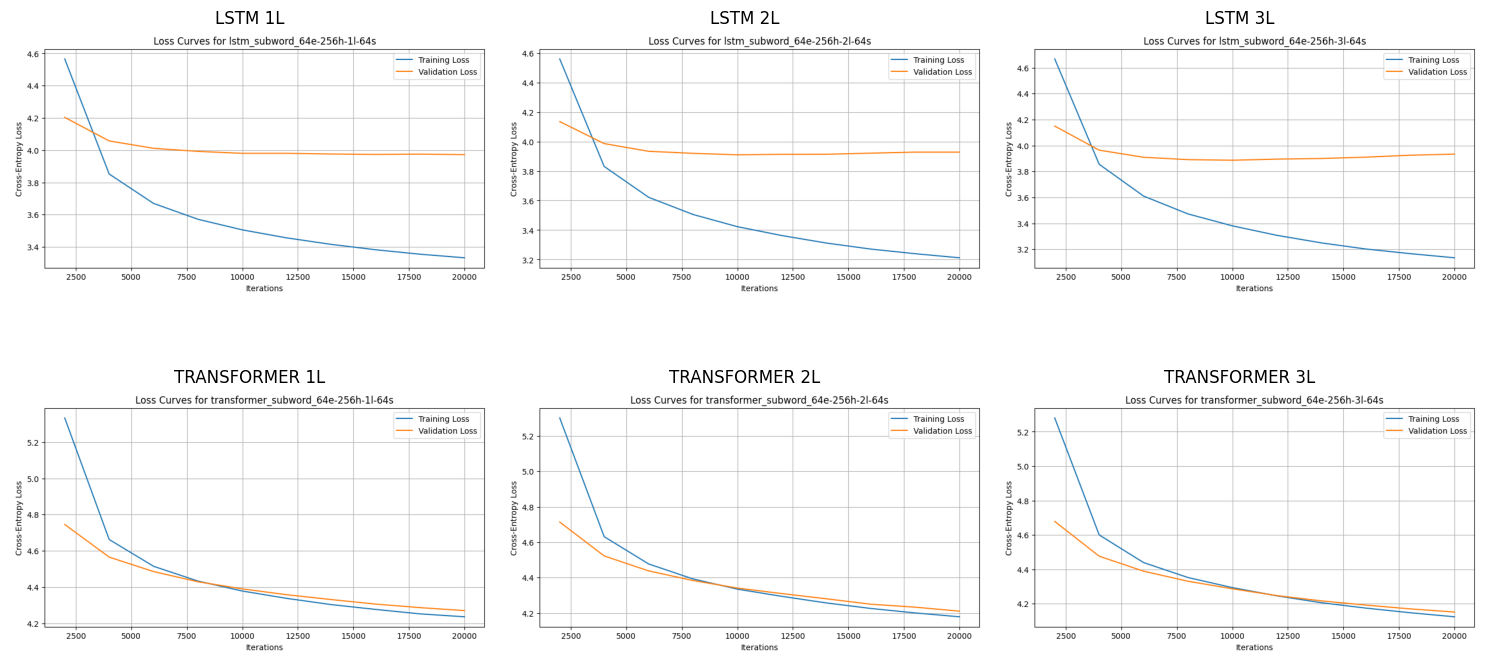

In [21]:
#| output: true
layers = ["1", "2", "3"]
models = ["lstm", "transformer"]
fig, axes = plt.subplots(len(models), len(layers), figsize=(15, 8))
for i, model_type in enumerate(models):
    for j, layer in enumerate(layers):
        ax = axes[i, j]
        matching = [exp for exp in results_log if exp.startswith(f"{model_type}_subword_64e-256h-{layer}l")]
        exp_name = matching[0]
        fig_path = os.path.join("figures", f"{exp_name}.png")
        img = Image.open(fig_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{model_type.upper()} {layer}L")
plt.tight_layout()
plt.show()

#### 3.2.3 Varying Sequence Length

We conduct experiments by varying the sequence length for both LSTM and Transformer models in {32, 64, 128}. Note that varying the sequence length does not change the number of parameters, it only affects the training time.

| Model            | Params (M) | Test Loss | Test Perplexity | Training Time (s) |
| ---------------- | ---------- | --------- | --------------- | ----------------- |
| LSTM 32s         | 1.50       | 3.94      | 51.63           | 4m 17s            |
| LSTM 64s         | 1.50       | 3.94      | 51.44           | 7m 21s            |
| LSTM 128s        | 1.50       | 3.91      | 49.65           | 14m 2s            |
| Transformer 32s  | 0.36       | 4.21      | 67.35           | 2m 57s            |
| Transformer 64s  | 0.36       | 4.17      | 64.92           | 3m 31s            |
| Transformer 128s | 0.36       | 4.16      | 63.16           | 5m 38s            |


In [22]:
experiments = [
    {'name': 'lstm_subword_64e-256h-2l-32s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 32},
    {'name': 'lstm_subword_64e-256h-2l-64s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'lstm_subword_64e-256h-2l-128s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 128},
    {'name': 'transformer_subword_64e-256h-2l-32s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 32},
    {'name': 'transformer_subword_64e-256h-2l-64s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 64},
    {'name': 'transformer_subword_64e-256h-2l-128s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 64, 'hidden_size': 256, 'num_layers': 2, 'seq_len': 128},
]

results_log = {}
for exp_config in experiments:
    results_log[exp_config['name']] = run_experiment(exp_config)
    print()

--- Model: lstm_subword_64e-256h-2l-32s | Parameters: 1.50M ---
Test Loss: 3.9441 | Test Perplexity: 51.6323

--- Model: lstm_subword_64e-256h-2l-64s | Parameters: 1.50M ---
Test Loss: 3.9404 | Test Perplexity: 51.4396

--- Model: lstm_subword_64e-256h-2l-128s | Parameters: 1.50M ---
Test Loss: 3.9050 | Test Perplexity: 49.6520

--- Model: transformer_subword_64e-256h-2l-32s | Parameters: 0.36M ---
Test Loss: 4.2100 | Test Perplexity: 67.3551

--- Model: transformer_subword_64e-256h-2l-64s | Parameters: 0.36M ---
Test Loss: 4.1731 | Test Perplexity: 64.9186

--- Model: transformer_subword_64e-256h-2l-128s | Parameters: 0.36M ---
Test Loss: 4.1457 | Test Perplexity: 63.1634



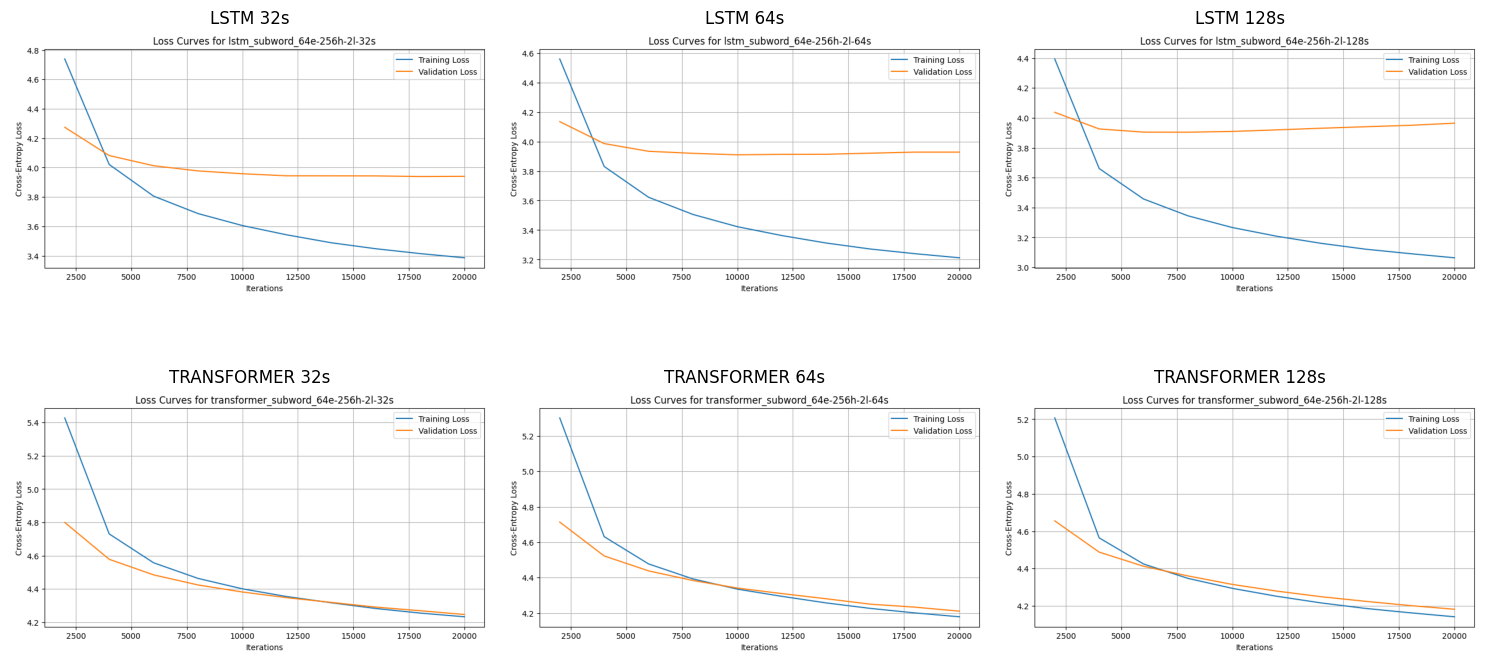

In [23]:
#| output: true
lengths = ["32", "64", "128"]
models = ["lstm", "transformer"]
fig, axes = plt.subplots(len(models), len(lengths), figsize=(15, 8))
for i, model_type in enumerate(models):
    for j, length in enumerate(lengths):
        ax = axes[i, j]
        matching = [exp for exp in results_log if exp.startswith(f"{model_type}_subword_64e-256h-2l-{length}s")]
        exp_name = matching[0]
        fig_path = os.path.join("figures", f"{exp_name}.png")
        img = Image.open(fig_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{model_type.upper()} {length}s")
plt.tight_layout()
plt.show()

Similar to the case of number of layers, increasing the sequence length improves the model's performance slightly and does not make models more susceptible to overfitting. Not surprisingly, training time increases with longer sequences, especially for the LSTM model since it processes sequences sequentially.

#### 3.2.4 Varying All 3 Factors Together

We choose the largest configuration from each of the previous experiments: Embedding size: $128$, Hidden size: $512$, Number of layers: $3$, Sequence length: $128$ to see how the models perform at a larger scale.

| Model                        | Params (M) | Test Loss | Test Perplexity | Training Time (s) |
| ---------------------------- | ---------- | --------- | --------------- | ----------------- |
| LSTM 128e 3L 128s            | 6.80       | 3.88      | 48.52           | 33m 51s           |
| **Transformer 128e 3L 128s** | **1.11**   | **3.83**  | **46.26**       | **9m 38s**        |


In [24]:
experiments = [
    {'name': 'lstm_subword_128e-512h-3l-128s', 'model_type': 'lstm', 'tokenizer': 'subword', 'embed_size': 128, 'hidden_size': 512, 'num_layers': 3, 'seq_len': 128},
    {'name': 'transformer_subword_128e-512h-3l-128s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 128, 'hidden_size': 512, 'num_layers': 3, 'seq_len': 128},
]

results_log = {}
for exp_config in experiments:
    results_log[exp_config['name']] = run_experiment(exp_config)
    print()

--- Model: lstm_subword_128e-512h-3l-128s | Parameters: 6.80M ---
Test Loss: 3.8819 | Test Perplexity: 48.5173

--- Model: transformer_subword_128e-512h-3l-128s | Parameters: 1.11M ---
Test Loss: 3.8343 | Test Perplexity: 46.2599



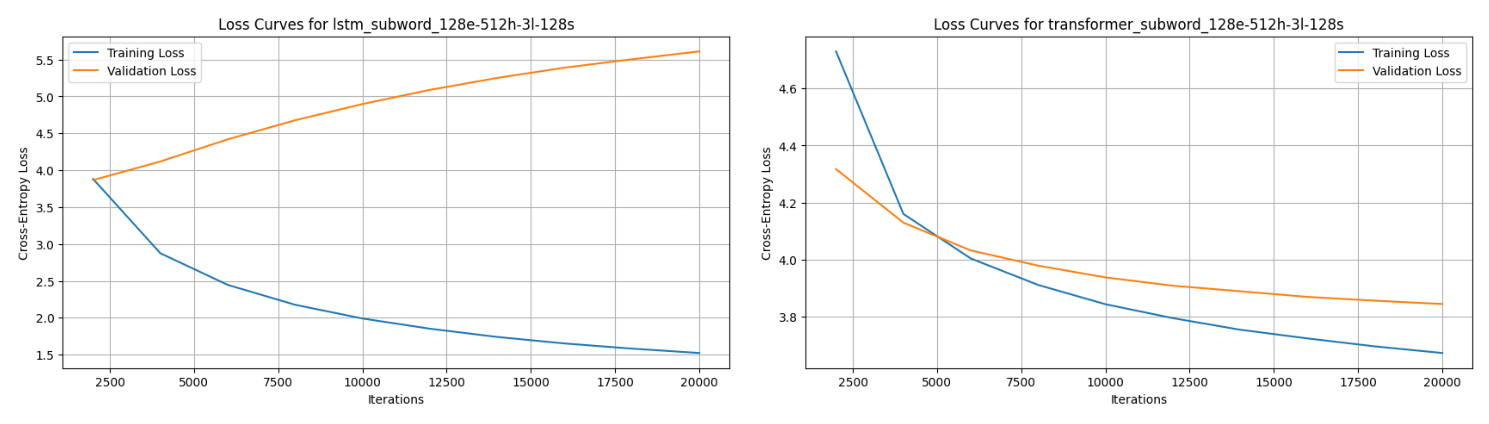

In [25]:
#| output: true
models = ["lstm", "transformer"]
fig, axes = plt.subplots(1, len(models), figsize=(15, 8))
for i, model_type in enumerate(models):
    ax = axes[i]
    matching = [exp for exp in results_log if exp.startswith(f"{model_type}_subword_128e-512h-3l-128s")]
    exp_name = matching[0]
    fig_path = os.path.join("figures", f"{exp_name}.png")
    img = Image.open(fig_path)
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()

Not surprisingly, the Transformer model scales better than the LSTM model, achieving lower perplexity with fewer parameters and significantly less training time. The training curves also suggest that the Transformer model trains more stably and we might still be able to train it for more iterations, or scale it even bigger to get even better performance.

### 3.3 Text Generation Experiments

Using the best model from the previous experiments `transformer_subword_128e-512h-3l-128s` with a test perplexity of **46.26**, we generate text samples with different temperature settings to observe the effect on the generated text.

In [26]:
#| output: true
experiments = [
    {'name': 'transformer_subword_128e-512h-3l-128s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 128, 'hidden_size': 512, 'num_layers': 3, 'seq_len': 128},
]
prompt = "Sherlock Holmes picked up a small piece of paper from the ground"
print(f"--- Prompt: '{prompt}' ---")
run_experiment(experiments[0], generate_only=True, prompt=prompt, temperature=0.7)
run_experiment(experiments[0], generate_only=True, prompt=prompt, temperature=1.0)
run_experiment(experiments[0], generate_only=True, prompt=prompt, temperature=1.3)

--- Prompt: 'Sherlock Holmes picked up a small piece of paper from the ground' ---
--- Generation from transformer_subword_128e-512h-3l-128s (temp=0.7) ---
s, and he was a number of action, and he had a telegram for heir, as he had seen, and his face showed that no difficulty was keenly well more
--- Generation from transformer_subword_128e-512h-3l-128s (temp=1.0) ---
s. We turned a tree and strength for a plantic and light from his climbler. "'The twenty of the houses, and there have whined
--- Generation from transformer_subword_128e-512h-3l-128s (temp=1.3) ---
. As he stood the doorway through with a lamp of neat,--one! that all happened," he asked. "Mr. we please. There does exactly no one either d


In [27]:
#| output: true
experiments = [
    {'name': 'transformer_subword_128e-512h-3l-128s', 'model_type': 'transformer', 'tokenizer': 'subword', 'embed_size': 128, 'hidden_size': 512, 'num_layers': 3, 'seq_len': 128},
]
prompt = "‘My dear Watson,’ said Holmes"
print(f"--- Prompt: '{prompt}' ---")
run_experiment(experiments[0], generate_only=True, prompt=prompt, temperature=0.7)
run_experiment(experiments[0], generate_only=True, prompt=prompt, temperature=1.0)
run_experiment(experiments[0], generate_only=True, prompt=prompt, temperature=1.3)

--- Prompt: '‘My dear Watson,’ said Holmes' ---
--- Generation from transformer_subword_128e-512h-3l-128s (temp=0.7) ---
, but I have anxious to work matter, for I am a sort of a very long time, and I have to attain. I shall be able to do, and can hardly tell
--- Generation from transformer_subword_128e-512h-3l-128s (temp=1.0) ---
, to grot  ⁇ , for I at last one day called three among this morning in Mr. Sherlock Holmes. He held a ribbled frank and gloomily dragged
--- Generation from transformer_subword_128e-512h-3l-128s (temp=1.3) ---
. It's cut the convention which won't show you; it may about a mere judgment oneize those which man must tell me perhaps upon eat about anything, nor


## Appendix

### A.1 Code & Model Weights

All code and model weights can be found at my GitHub repository: [https://github.com/ncduy0303/dsa4213-assignment-2](https://github.com/ncduy0303/dsa4213-assignment-2). More instructions are provided in the repository's README.

### A.2 AI Tool Declaration

I used Gemini 2.5 Pro and Github Copilot to generate ideas, format paragraphs, improve expression, produce drafts, refine, and finalize my assignment. I am responsible for the content and quality of the submitted work.